# Data Preparation & Exploration 

In [38]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
%pylab inline
from datetime import datetime
import pickle 
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import category_encoders as ce
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
import shap

pd.set_option('display.max_rows', 500)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sklearn
sklearn.__version__

'0.21.3'

In [3]:
TODO = 100000
train = pd.read_pickle("train_set.pickle").sample(n=TODO)
train.loc[:,"clicked"] = train.loc[:,"clicked"].map({True:1, False:0})



In [4]:

#TODO replace with Ayelet code
train.loc[:,'time'] = pd.to_datetime(train['timestamp'], unit='s')
train.loc[:,'Day_of_Week'] = train['time'].dt.weekday_name

# note monday == 0 
train.loc[:,'weekend'] = train['time'].dt.dayofweek > 4

train.loc[:,'Month'] = train['time'].dt.month_name().str[:3]
train.loc[:,'hour'] = train['time'].dt.hour

train.loc[:,'device_diag'] = np.sqrt(train.device_height^2 + train.device_width^2).round()
train.loc[:,'manufacturer'] = train['manufacturer'].fillna('Unknown')

In [5]:
train_df, other = train_test_split(train, test_size=0.3, random_state=42)
dev_val, other2 = train_test_split(other, test_size=2/3, random_state=42)
dev_test, dev_es = train_test_split(other2, test_size=0.5, random_state=42)

In [6]:
train_df.shape, dev_val.shape, dev_es.shape, dev_test.shape

((70000, 18), (10000, 18), (10000, 18), (10000, 18))

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 570861 to 2265421
Data columns (total 18 columns):
timestamp         70000 non-null int64
state             70000 non-null object
user_isp          70000 non-null object
app_id            70000 non-null object
app_cat           70000 non-null object
banner_pos        70000 non-null object
manufacturer      70000 non-null object
device_model      48412 non-null object
device_version    70000 non-null object
device_height     70000 non-null int64
device_width      70000 non-null int64
clicked           70000 non-null int64
time              70000 non-null datetime64[ns]
Day_of_Week       70000 non-null object
weekend           70000 non-null bool
Month             70000 non-null object
hour              70000 non-null int64
device_diag       70000 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(5), object(10)
memory usage: 9.7+ MB


In [8]:
# TODO update features list
features = ['app_cat', 'banner_pos', 'device_diag', 'state' , 'Day_of_Week', 'Month', 'hour' , 'device_version' , 'manufacturer']
cat_features = ['app_cat','banner_pos','state' ,  'Day_of_Week', 'Month', 'hour','device_version' , 'manufacturer']

In [9]:
X_train = train_df[features]
y_train = train_df['clicked']
X_val = dev_val[features]
y_val = dev_val['clicked']
X_es  = dev_es[features]
y_es = dev_es['clicked']

# exploring the Target Encoder

In [10]:
encoder = ce.TargetEncoder(cols=cat_features)
encoder.fit(X_train, y_train)


TargetEncoder(cols=['app_cat', 'banner_pos', 'state', 'Day_of_Week', 'Month',
                    'hour', 'device_version', 'manufacturer'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', min_samples_leaf=1, return_df=True,
              smoothing=1.0, verbose=0)

In [11]:
X_val_encoded = encoder.fit_transform(X_val, y_val)

In [12]:
X_val_encoded.describe()

,app_cat,banner_pos,device_diag,state,Day_of_Week,Month,hour,device_version,manufacturer
count,1.000000e+04,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,6.835783e-02,0.068300,40.738800,6.829984e-02,0.068300,0.068300,0.068300,0.068300,0.068276
std,2.183909e-02,0.071139,9.442049,1.857897e-02,0.006105,0.007637,0.015966,0.005884,0.018968
min,2.350675e-15,0.000000,0.000000,3.826710e-10,0.058691,0.055556,0.030641,0.063115,0.000008
25%,5.815062e-02,0.000000,31.000000,6.229508e-02,0.062500,0.059322,0.056000,0.064499,0.059571
50%,6.669446e-02,0.000000,45.000000,6.775408e-02,0.066710,0.068723,0.068762,0.065714,0.059871
75%,7.679739e-02,0.134255,45.000000,7.522796e-02,0.072662,0.069752,0.082883,0.070346,0.080443
max,2.941176e-01,0.155844,64.000000,2.500000e-01,0.077848,0.089873,0.092857,0.115385,0.383898


# Preparing for pipeline creation

In [13]:
def plot_auc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.3f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

In [14]:

def plot_calibration(y, y_hat):
    # reliability diagram
    fop, mpv = calibration_curve(y, y_hat, n_bins=10, normalize=True)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pyplot.plot(mpv, fop, marker='.')
    plt.xlabel("Mean predicted probabilities")
    plt.ylabel("True Probabilities")
    plt.title("Calibration Curve")
    pyplot.show()

In [15]:
def find_threshold(y, y_hat):
    num_actual_clicks = sum(y)
    threshold = 0.5
    num_predicted_clicks = sum(y[y_hat>=threshold])
    while num_predicted_clicks < num_actual_clicks:
        threshold = threshold - 0.01
        num_predicted_clicks = sum(y[y_hat>=threshold])
        #print (f"""threshold:{threshold}, num_predicted_clicks:{num_predicted_clicks}""")
    
    return threshold

In [16]:
def find_threshold_by_accuracy(y, y_hat, plot=False):
    threshold = []
    accuracy = []
    for p in np.sort(np.unique(y_hat))[-50:]:
        threshold.append(p)
        y_pred = (y_hat >= p).astype(int)
        curr_accuracy = accuracy_score(y,y_pred)
        accuracy.append(curr_accuracy)
    best_threshold = threshold[np.argmax(np.array(accuracy), axis=0)]
    best_accuracy = max(accuracy)
    print ("Best Threshold:" ,best_threshold, ", with accuracy = ", best_accuracy)
    if plot:
        plt.scatter(threshold,accuracy)
        plt.xlabel("Threshold")
        plt.ylabel("Accuracy")
        plt.show()
    return best_accuracy, best_threshold

In [17]:
def find_threshold_by_logloss(y, y_hat, plot=False):
    threshold = []
    logloss = []
    for p in np.sort(np.unique(y_hat))[-50:]:
        threshold.append(p)
        y_pred = (y_hat >= p).astype(int)
        curr_logloss = -log_loss(y,y_pred)
        logloss.append(curr_logloss)
    best_threshold = threshold[np.argmax(np.array(logloss), axis=0)]
    best_logloss = max(logloss)
    print ("Best Threshold:" ,best_threshold, ", with logloss = ", best_logloss)
    return best_logloss, best_threshold

In [18]:

def find_best_params_random_forest(grid, X_train, y_train, X_val, y_val):
    best_accuracy = 0
    worst_accuracy = 1
    for g in ParameterGrid(grid):
        print(g)
        rf_pipe = make_rf_pipe_line(None, params = g)
        rf_pipe.fit(X_train,y_train)
        y_hat = rf_pipe.predict_proba(X_val)[:,1]
        curr_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)

        # save if best
        if curr_accuracy > best_accuracy:
            best_accuracy = curr_accuracy
            best_grid = g
            
        if curr_accuracy < worst_accuracy:
            worst_accuracy = curr_accuracy
            worst_grid = g
    print ("Final Result")
    print ("best accuracy", best_accuracy, ", Grid:", best_grid)
    print ("worst accuracy", worst_accuracy, ", Grid:", best_grid)
    return best_grid

In [20]:
def evaulate_pipeline(pipe, X, y):
    y_hat = pipe.predict_proba(X)[:,1]
    assert y.shape ==  y_hat.shape
    best_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)
    
    y_pred = (y_hat >= best_threshold).astype(int)

 
    fpr, tpr, thresholds = metrics.roc_curve(y, y_hat, pos_label=1)
    auc = plot_auc(fpr, tpr)
    plot_calibration(y, y_hat)
    #plt.hist(y_hat[y_hat >= 0], bins=10, density=False)
    plt.hist(y_hat, bins=100, density=True)
    plt.title("Histogram of predicted probabilities for click")
    plt.show()
    #threshold = find_threshold(y, y_hat)
    #print (f"""threshold={threshold:.2f}, num clicks: predicted={sum(y[y_hat>=threshold])}, actual={sum(y)}""")
    print("Accuracy:", accuracy_score(y, y_pred, normalize=True))
    print("Recall:", recall_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("AUC:", auc)
    #print("-logloss:", -log_loss(y, y_hat))
    

# Random Forest PipeLine

In [22]:
def make_rf_pipe_line(calibration = None, params = None ):
    assert calibration is None or calibration in ['isotonic', 'sigmoid']
    encoder = ce.TargetEncoder(cols=cat_features)
    rf = RandomForestClassifier(n_estimators = 200, max_depth=5, criterion = "gini", n_jobs = 4,
                                min_samples_split=100,random_state=13)
    if params:
        rf.set_params(**params)
    if calibration is None:
        rf_pipe = Pipeline([('target_enc',encoder),  ('classifier', rf)])
    else:
        calibrated_RF_classifier =  CalibratedClassifierCV(base_estimator=rf, cv=5, method=calibration)
        rf_pipe = Pipeline([('target_enc',encoder),  ('calibrated_classifier', calibrated_RF_classifier)])
    rf_pipe.fit(X_train, y_train)
    return rf_pipe


In [ ]:
%%time

rf_params_grid ={'min_samples_leaf': [100], 
                 'max_depth': [4] ,
                 'class_weight' : ['balanced'],
                 'n_estimators': [100],
                 'criterion': ["gini"]
                 
                }
best_rf_params = find_best_params_random_forest(rf_params_grid, X_train, y_train, X_val, y_val)

In [23]:

rf_pipe = make_rf_pipe_line(calibration = None, params = best_rf_params)


Best Threshold: 0.2806451346383562 , with accuracy =  0.9316


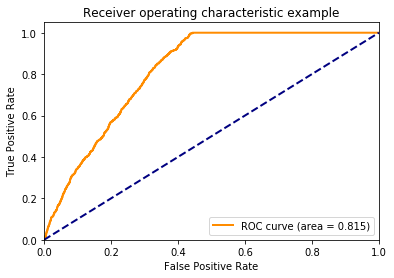

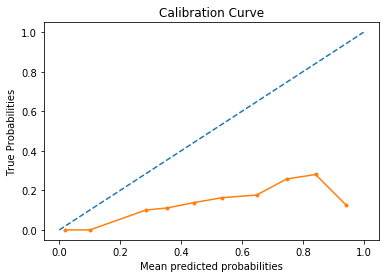

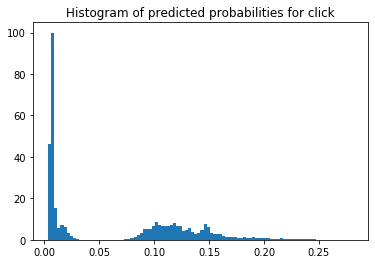

Accuracy: 0.9316
Recall: 0.0
Precision: 0.0
AUC: 0.8151215578946905


In [24]:

evaulate_pipeline(rf_pipe, X_val, y_val)

# Cat Boost Model

In [25]:
validation_pool = Pool(data = X_val, label = y_val, cat_features=cat_features)
train_pool = Pool(data = X_train, label = y_train, cat_features=cat_features)
es_pool = Pool(data = X_es, label = y_es, cat_features=cat_features)


In [28]:
def make_catboost_pipe_line(train_pool, es_pool, class_weight = None, target_encoder = False, params = None):
    model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features=cat_features,
                               depth=5,
                               custom_loss = ['AUC', 'Logloss','BrierScore', 'Precision', 'Recall'],
                               early_stopping_rounds = 20,
                               auto_class_weights = class_weight,
                               subsample= 0.5,
                               verbose=30)
    if params:
        model.set_params(**params)
    model.fit(train_pool, eval_set=es_pool, plot=True)
    return model


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.122348
0:	learn: 0.5668049	test: 0.5674885	best: 0.5674885 (0)	total: 143ms	remaining: 1m 11s
30:	learn: 0.1904459	test: 0.1945566	best: 0.1945566 (30)	total: 3.03s	remaining: 45.9s
60:	learn: 0.1892450	test: 0.1942043	best: 0.1942043 (60)	total: 6.23s	remaining: 44.8s
90:	learn: 0.1883480	test: 0.1941890	best: 0.1941397 (70)	total: 9.36s	remaining: 42.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1941396916
bestIteration = 70

Shrink model to first 71 iterations.


In [56]:
catboost_params_grid ={ 'depth': [4,6,8] ,
                 'min_child_samples' : [100,500,1000],
                 'n_estimators': [100,200],
                  'subsample': [0.5,0.75,0.95],
                       
                }
#find_best_params_catboost(catboost_params_grid, train_pool, es_pool, X_val, y_val)

In [57]:
model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features=cat_features,
                               depth=5,
                               early_stopping_rounds = 20,
                               auto_class_weights = 'Balanced',
                               subsample= 0.5,
                               verbose=30)
search_results = model.randomized_search(catboost_params_grid,
                  train_pool,
                  y=None,
                  cv=3,
                  n_iter=10,
                  partition_random_seed=0,
                  calc_cv_statistics=True,
                  search_by_train_test_split=True,
                  refit=True,
                  shuffle=True,
                  stratified=None,
                  train_size=0.8,
                  verbose=False,
                  log_cout=sys.stdout,
                  log_cerr=sys.stderr)

0:	learn: 0.6529782	test: 0.6528698	best: 0.6528698 (0)	total: 84.8ms	remaining: 16.9s
30:	learn: 0.4506841	test: 0.4526698	best: 0.4526698 (30)	total: 1.85s	remaining: 10.1s
60:	learn: 0.4383290	test: 0.4421673	best: 0.4421673 (60)	total: 3.66s	remaining: 8.33s
90:	learn: 0.4347377	test: 0.4389296	best: 0.4389296 (90)	total: 5.68s	remaining: 6.81s
120:	learn: 0.4331797	test: 0.4379269	best: 0.4379269 (120)	total: 7.6s	remaining: 4.96s
150:	learn: 0.4322674	test: 0.4374267	best: 0.4374238 (147)	total: 9.89s	remaining: 3.21s
180:	learn: 0.4313804	test: 0.4369844	best: 0.4369844 (180)	total: 12.4s	remaining: 1.3s
199:	learn: 0.4309937	test: 0.4367858	best: 0.4367843 (198)	total: 13.8s	remaining: 0us

bestTest = 0.4367842763
bestIteration = 198

0:	learn: 0.6529782	test: 0.6528698	best: 0.6528698 (0)	total: 79.7ms	remaining: 7.89s
30:	learn: 0.4541130	test: 0.4554878	best: 0.4554878 (30)	total: 1.56s	remaining: 3.47s
60:	learn: 0.4396550	test: 0.4435387	best: 0.4435387 (60)	total: 3.19s	r

### optimized configuration for catboost

In [58]:
search_results['params']

{'min_data_in_leaf': 500, 'depth': 8, 'iterations': 200, 'subsample': 0.95}

### Train a final cat boost model with the optimized params

In [59]:
catboost_pipe = make_catboost_pipe_line(train_pool, es_pool, target_encoder = False, params = search_results['params'])


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.182264
0:	learn: 0.5141893	test: 0.5152063	best: 0.5152063 (0)	total: 145ms	remaining: 28.9s
30:	learn: 0.1873183	test: 0.1941572	best: 0.1941521 (26)	total: 5.01s	remaining: 27.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1941521336
bestIteration = 26

Shrink model to first 27 iterations.


Best Threshold: 0.38097752336490515 , with accuracy =  0.9316


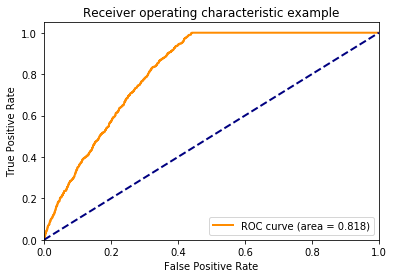

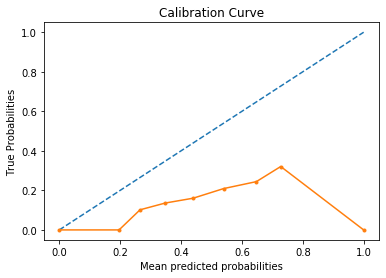

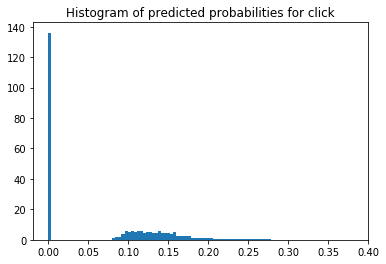

Accuracy: 0.9316
Recall: 0.0
Precision: 0.0
AUC: 0.8184913171360905


In [60]:
evaulate_pipeline(catboost_pipe, X_val, y_val)

# KNN Classifier Model

In [63]:
def make_knn_pipe_line(params = None) :
    encoder = ce.TargetEncoder(cols=cat_features)
    knn_model = KNeighborsClassifier(n_neighbors=300, weights='uniform')
    if params:
        knn_model.set_params(**params)
    return (Pipeline([('target_enc',encoder),  ('scaler',  StandardScaler()), ('KNN', knn_model)]))   

In [66]:
def find_best_params_knn(grid,X_train, y_train, X_val, y_val):
    best_accuracy = 0
    worst_accuracy = 1
    for g in ParameterGrid(grid):
        print(g)
        model = make_knn_pipe_line(params = g)
        model.fit(X_train, y_train)
        y_hat = model.predict_proba(X_val)[:,1]
        curr_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)

        # save if best
        if curr_accuracy > best_accuracy:
            best_accuracy = curr_accuracy
            best_grid = g
            
        if curr_accuracy < worst_accuracy:
            worst_accuracy = curr_accuracy
            worst_grid = g
    print ("Final Result")
    print ("best accuracy", best_accuracy, ", Grid:", best_grid)
    print ("worst accuracy", worst_accuracy, ", Grid:", best_grid)
    return best_grid

In [67]:
%%time

knn_params_grid ={'n_neighbors': [100, 500, 1000], 
                 'weights': ['uniform' , 'distance'],
                  'leaf_size' : [30,100]
                }
best_knn_params = find_best_params_knn(knn_params_grid, X_train, y_train, X_val, y_val)

{'n_neighbors': 100, 'weights': 'uniform'}
Best Threshold: 0.43 , with accuracy =  0.9318
{'n_neighbors': 100, 'weights': 'distance'}
Best Threshold: 1.0 , with accuracy =  0.9313
{'n_neighbors': 500, 'weights': 'uniform'}
Best Threshold: 0.308 , with accuracy =  0.9318
{'n_neighbors': 500, 'weights': 'distance'}
Best Threshold: 1.0 , with accuracy =  0.9313
{'n_neighbors': 1000, 'weights': 'uniform'}
Best Threshold: 0.276 , with accuracy =  0.9316
{'n_neighbors': 1000, 'weights': 'distance'}
Best Threshold: 1.0 , with accuracy =  0.9313
Final Result
best accuracy 0.9318 , Grid: {'n_neighbors': 100, 'weights': 'uniform'}
worst accuracy 0.9313 , Grid: {'n_neighbors': 100, 'weights': 'uniform'}
Wall time: 1min 56s


In [71]:
knn_pipeline = make_knn_pipe_line(params = best_knn_params)
knn_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('target_enc',
                 TargetEncoder(cols=['app_cat', 'banner_pos', 'state',
                                     'Day_of_Week', 'Month', 'hour',
                                     'device_version', 'manufacturer'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('KNN',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=100, p=2,
                                      weights='uniform'))],
         verbose=False)

Best Threshold: 0.43 , with accuracy =  0.9318


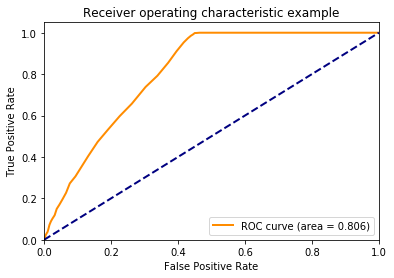

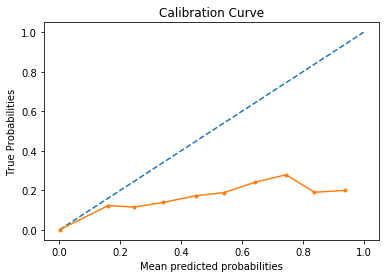

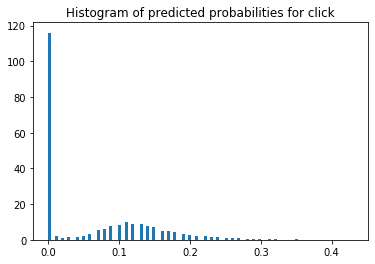

Accuracy: 0.9318
Recall: 0.0014641288433382138
Precision: 1.0
AUC: 0.8060107069823562


In [72]:
evaulate_pipeline(knn_pipeline, X_val, y_val)

# Shap Values

In [74]:
model = catboost_pipe


# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.initjs()


Shap Values (Shapely Additive exPlanations is a model Agnostic method for explaining model predictions
It is based on theory developed by Loid Shapley in the 1950's 

# Shap Summary Plot

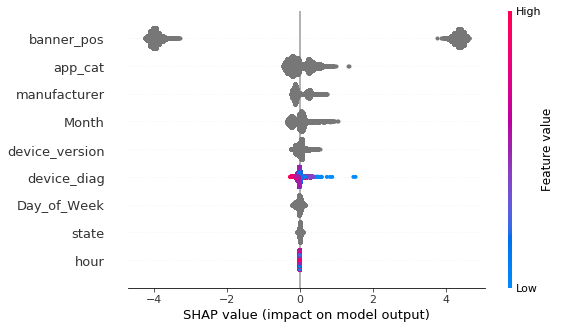

In [77]:

shap.summary_plot(shap_values)

In [80]:

def explain_simple(idx, X_train):
    data = X_train.iloc[[idx]]
    shap_values = explainer.shap_values( data)
    return (shap.force_plot(explainer.expected_value,shap_values , data, link='logit'))

# 3 random prediction explanations

In [85]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [83]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [86]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)